# Visualization for third level

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../.'))
import os.path as op
import numpy as np
import torch
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots 
plt.style.use("science")
%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update({'font.size': 16})

import utils
from models.pc_three_linear import DynPredNet
import models.data_loader as data_loader
from evaluation import record_three

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
fpath = "../experiments/three/"
data_dir = "../data/three"
params = utils.Params(op.join(fpath, 'params.json'))
params.cuda = True
params.shuffle = False # to compare with labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = DynPredNet(params, device).to(device)
ckpt = utils.load_checkpoint(op.join(fpath, 'last.pth.tar'), model)
model.eval()

dataloaders = data_loader.fetch_dataloader(['test'], data_dir, params)
dl = dataloaders['test']
X = dl.dataset.data[:params.batch_size].to(device)

## Two examples of straight vs. clockwise bouncing

In [5]:
result_dict = record_three(model, X, input_dim=params.input_dim)

In [6]:
I_bar_first = result_dict["I_bar_first"]
I_bar_sec = result_dict["I_bar_sec"]
I_hat = result_dict["I_hat"]
I = result_dict["I"]
Error = result_dict["Error"]

### Straight bouncing

In [7]:
b = 58
I_b = I[b] 
I_bar_b = I_bar_first[b]
I_bar_b[Error[b] == 1] = I_bar_sec[b][Error[b] == 1]
I_hat_b = I_hat[b]
I_err_b = (I_b - I_bar_b)
I_err_b = (I_err_b - I_err_b.min()) / (I_err_b.max() - I_err_b.min())

/tmp/ipykernel_7189/2817444076.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


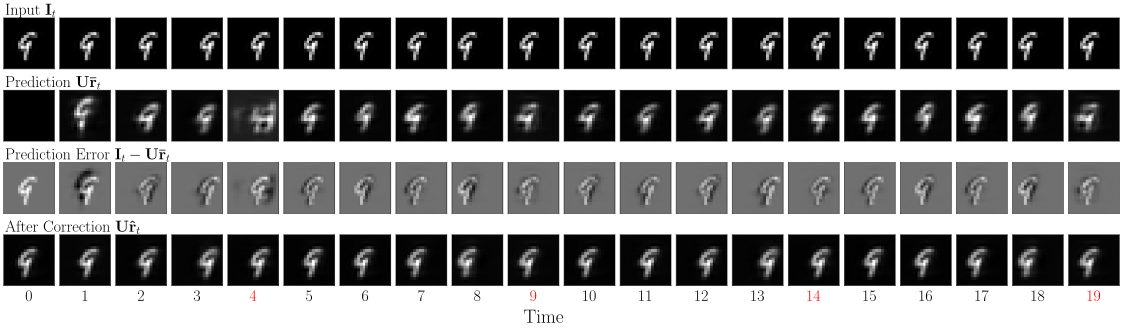

In [8]:
fig = plt.figure(figsize=[20, 5])
T = I_hat.shape[1]
N = 18
grid = plt.GridSpec(4, T, wspace=0.1, hspace=0.2)
for t in range(T):
    ax = fig.add_subplot(grid[0, t])
    ax.imshow(I_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([]) 
    if t == 0:
        ax.text(0, -0.55, r"Input $\mathbf{I}_t$",  ha='left', va='bottom')
        
    ax = fig.add_subplot(grid[1, t])
    ax.imshow(I_bar_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([])  
    if t == 0:
        ax.text(0, -0.55, r"Prediction $\mathbf{U}\mathbf{\bar{r}}_t$",  ha='left', va='bottom')

    ax = fig.add_subplot(grid[2, t])
    ax.imshow(I_err_b[t].reshape(N, N), "gray", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if t == 0:
        ax.text(0, -0.55, r"Prediction Error $\mathbf{I}_t - \mathbf{U}\mathbf{\bar{r}}_t$",  ha='left', va='bottom')
        
    ax = fig.add_subplot(grid[3, t])
    ax.imshow(I_hat_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if t == 0:
        ax.text(0, -0.55, r"After Correction $\mathbf{U}\mathbf{\hat{r}}_t$",  ha='left', va='bottom')
    ax.set_xlabel(f"{t}", color="red" if result_dict["Error"][b,t] else "black")
fig.supxlabel('Time', y=0.01)        
plt.tight_layout()

In [9]:
fig.savefig("figures/three_straight.pdf", bbox_inches='tight', pad_inches=0)

In [10]:
### NORMALIZE
Rb = result_dict["R_hat"][b,:,:]
Rb = (Rb - Rb.min()) / (Rb.max() - Rb.min())
Rh = result_dict["R2_hat"][b]
Rh = (Rh - Rh.min()) / (Rh.max() - Rh.min())
R3 = result_dict["R3_hat"][b]
R3 = (R3 - R3.min()) / (R3.max() - R3.min())
w = result_dict["W_hat"][b]
w = (w - w.min()) / (w.max() - w.min())
w2 = result_dict["W2_hat"][b]
w2 = (w2 - w2.min()) / (w2.max() - w2.min())

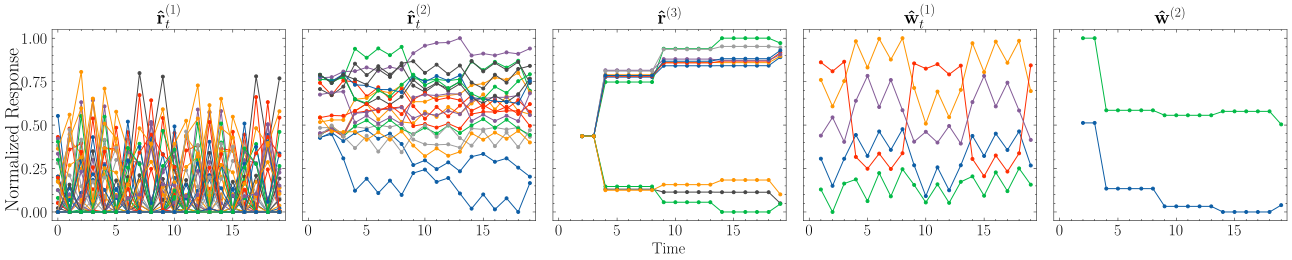

In [11]:
### PLOT
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=[18, 4])
ax_r = axes[0]
for i in range(100):
    ax_r.plot(Rb[:, i], marker='o', markersize=3)  
ax_r.set_xlim(-0.5, T - 0.5)
ax_r.set_title(r"$\mathbf{\hat{r}}^{(1)}_t$")

ax_r2 = axes[1]
for i in range(Rh.shape[1]):
    ax_r2.plot(np.arange(1, T), Rh[1:, i], marker='o', markersize=3)  
ax_r2.set_xlim(-0.5, T - 0.5)
ax_r2.set_title(r"$\mathbf{\hat{r}}^{(2)}_t$") 

ax_rs = axes[2]
for i in range(R3.shape[1]):
    ax_rs.plot(np.arange(2, T), R3[2:, i], marker='o', markersize=3)  
ax_rs.set_xlim(-0.5, T - 0.5)
ax_rs.set_title(r"$\mathbf{\hat{r}}^{(3)}$") 
ax_rs.set_xlabel("Time")

ax_r = axes[3]
for i in range(w.shape[1]):
    ax_r.plot(np.arange(1, T), w[1:, i], marker='o', markersize=3)  
ax_r.set_xlim(-0.5, T - 0.5)
ax_r.set_title(r"$\mathbf{\hat{w}}^{(1)}_t$")

ax_r2 = axes[4]
for i in range(w2.shape[1]):
    ax_r2.plot(np.arange(2, T), w2[2:, i], marker='o', markersize=3)  
ax_r2.set_xlim(-0.5, T - 0.5)
ax_r2.set_title(r"$\mathbf{\hat{w}}^{(2)}$") 

plt.tight_layout()
fig.supylabel("Normalized Response", x=-0.005)
plt.subplots_adjust(hspace=0.25)

In [12]:
fig.savefig("figures/three_straight_responses.pdf", bbox_inches='tight', pad_inches=0)

### Clockwise bouncing

90, 101, 112

In [13]:
b = 90
I_b = I[b] 
I_bar_b = I_bar_first[b]
I_bar_b[Error[b] == 1] = I_bar_sec[b][Error[b] == 1]
I_hat_b = I_hat[b]
I_err_b = (I_b - I_bar_b)
I_err_b = (I_err_b - I_err_b.min()) / (I_err_b.max() - I_err_b.min())

/tmp/ipykernel_7189/2817444076.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


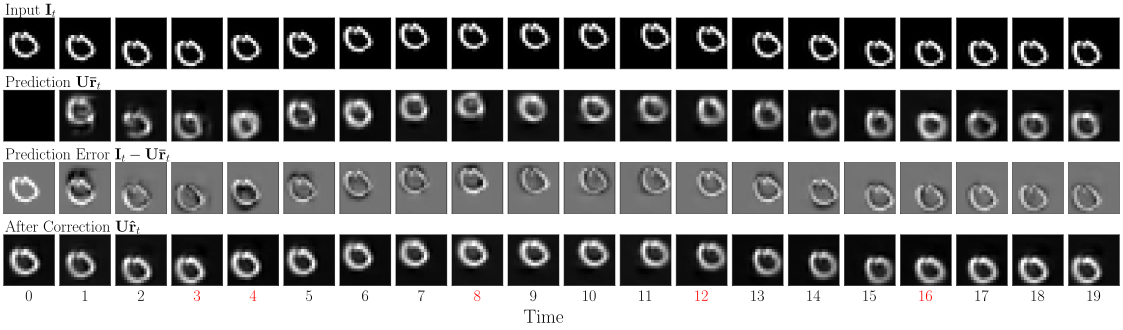

In [14]:
fig = plt.figure(figsize=[20, 5])
T = I_hat.shape[1]
N = 18
grid = plt.GridSpec(4, T, wspace=0.1, hspace=0.2)
for t in range(T):
    ax = fig.add_subplot(grid[0, t])
    ax.imshow(I_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([]) 
    if t == 0:
        ax.text(0, -0.55, r"Input $\mathbf{I}_t$",  ha='left', va='bottom')
        
    ax = fig.add_subplot(grid[1, t])
    ax.imshow(I_bar_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([])  
    if t == 0:
        ax.text(0, -0.55, r"Prediction $\mathbf{U}\mathbf{\bar{r}}_t$",  ha='left', va='bottom')

    ax = fig.add_subplot(grid[2, t])
    ax.imshow(I_err_b[t].reshape(N, N), "gray", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if t == 0:
        ax.text(0, -0.55, r"Prediction Error $\mathbf{I}_t - \mathbf{U}\mathbf{\bar{r}}_t$",  ha='left', va='bottom')
        
    ax = fig.add_subplot(grid[3, t])
    ax.imshow(I_hat_b[t].reshape(N, N), "gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if t == 0:
        ax.text(0, -0.55, r"After Correction $\mathbf{U}\mathbf{\hat{r}}_t$",  ha='left', va='bottom')
    ax.set_xlabel(f"{t}", color="red" if result_dict["Error"][b,t] else "black")
fig.supxlabel('Time', y=0.01)        
plt.tight_layout()

In [15]:
fig.savefig("figures/three_clock.pdf", bbox_inches='tight', pad_inches=0)

In [16]:
### NORMALIZE
Rb = result_dict["R_hat"][b,:,:]
Rb = (Rb - Rb.min()) / (Rb.max() - Rb.min())
Rh = result_dict["R2_hat"][b]
Rh = (Rh - Rh.min()) / (Rh.max() - Rh.min())
R3 = result_dict["R3_hat"][b]
R3 = (R3 - R3.min()) / (R3.max() - R3.min())
w = result_dict["W_hat"][b]
w = (w - w.min()) / (w.max() - w.min())
w2 = result_dict["W2_hat"][b]
w2 = (w2 - w2.min()) / (w2.max() - w2.min())

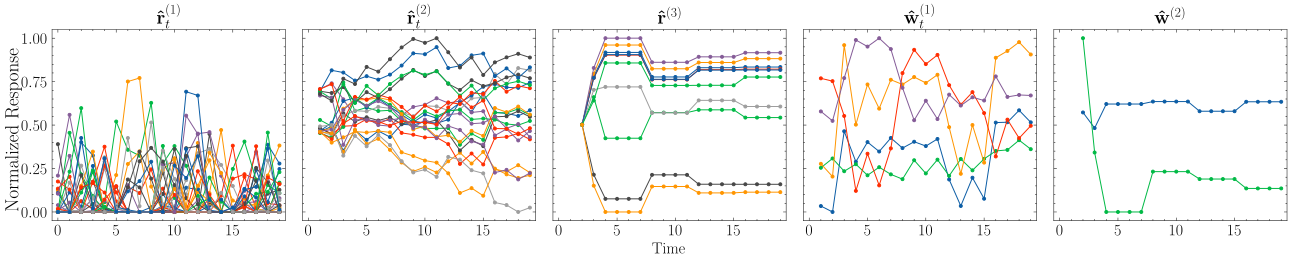

In [17]:
### PLOT
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=[18, 4])
ax_r = axes[0]
for i in range(50):
    ax_r.plot(Rb[:, i], marker='o', markersize=3)  
ax_r.set_xlim(-0.5, T - 0.5)
ax_r.set_title(r"$\mathbf{\hat{r}}^{(1)}_t$")

ax_r2 = axes[1]
for i in range(Rh.shape[1]):
    ax_r2.plot(np.arange(1, T), Rh[1:, i], marker='o', markersize=3)  
ax_r2.set_xlim(-0.5, T - 0.5)
ax_r2.set_title(r"$\mathbf{\hat{r}}^{(2)}_t$") 

ax_rs = axes[2]
for i in range(R3.shape[1]):
    ax_rs.plot(np.arange(2, T), R3[2:, i], marker='o', markersize=3)  
ax_rs.set_xlim(-0.5, T - 0.5)
ax_rs.set_title(r"$\mathbf{\hat{r}}^{(3)}$") 
ax_rs.set_xlabel("Time")

ax_r = axes[3]
for i in range(w.shape[1]):
    ax_r.plot(np.arange(1, T), w[1:, i], marker='o', markersize=3)  
ax_r.set_xlim(-0.5, T - 0.5)
ax_r.set_title(r"$\mathbf{\hat{w}}^{(1)}_t$")

ax_r2 = axes[4]
for i in range(w2.shape[1]):
    ax_r2.plot(np.arange(2, T), w2[2:, i], marker='o', markersize=3)  
ax_r2.set_xlim(-0.5, T - 0.5)
ax_r2.set_title(r"$\mathbf{\hat{w}}^{(2)}$") 

plt.tight_layout()
fig.supylabel("Normalized Response", x=-0.005)
plt.subplots_adjust(hspace=0.25)

In [18]:
fig.savefig("figures/three_clock_responses.pdf", bbox_inches='tight', pad_inches=0)

## Decoding

In [5]:
# go through test set and record r2 and r3 representation
R2 = None
R3 = None
W = None
W2 = None
for data_batch in dl:
    data_batch = data_batch.to(device)
    result_dict = record_three(model, data_batch, input_dim=params.input_dim)
    R2 = result_dict['R2_hat'] if R2 is None else np.concatenate((R2, result_dict['R2_hat']), axis=0)
    R3 = result_dict['R3_hat'] if R3 is None else np.concatenate((R3, result_dict['R3_hat']), axis=0)
    W = result_dict['W_hat'] if W is None else np.concatenate((W, result_dict['W_hat']), axis=0)
    W2 = result_dict['W2_hat'] if W2 is None else np.concatenate((W2, result_dict['W2_hat']), axis=0)

In [6]:
# load motion and bouncing labels
motion = np.load(op.join(data_dir, 'motion_test.npy'))
bouncing = np.load(op.join(data_dir, 'bouncing_test.npy'))
bouncing = np.tile(bouncing, (1, 20))

In [7]:
# remove the first three time steps
R2 = R2[:, 3:, :]
R3 = R3[:, 3:, :]
W = W[:, 3:, :]
W2 = W2[:, 3:, :]
motion = motion[:, 3:]
bouncing = bouncing[:, 3:]

### Decoding from mixture weights

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

In [9]:
cv_motion_r2 = cross_validate(SVC(), W.reshape(-1, model.mix_dim), motion.reshape(-1), cv=10)
cv_bouncing_r2 = cross_validate(SVC(), W.reshape(-1, model.mix_dim), bouncing.reshape(-1), cv=10)
cv_motion_r3 = cross_validate(SVC(), W2.reshape(-1, model.mix_dim_2), motion.reshape(-1), cv=10)
cv_bouncing_r3 = cross_validate(SVC(), W2[:,-1,:].reshape(-1, model.mix_dim_2), bouncing[:,-1].reshape(-1), cv=10)

In [10]:
motion_cat = motion.reshape(-1)
bouncing_cat = bouncing.reshape(-1)

In [11]:
motion_chance = np.where(motion_cat == np.argmax(np.bincount(motion_cat.astype(int))))[0].shape[0] / motion_cat.shape[0]
bouncing_chance = np.where(bouncing_cat == np.argmax(np.bincount(bouncing_cat.astype(int))))[0].shape[0] / bouncing_cat.shape[0]

In [16]:
print(motion_chance)
print(bouncing_chance)

0.25458823529411767
0.5


In [18]:
print(cv_bouncing_r3["test_score"].mean())
print(cv_bouncing_r2["test_score"].mean())
print(cv_motion_r3["test_score"].mean())
print(cv_motion_r2["test_score"].mean())


0.9269999999999999
0.6635882352941176
0.3801764705882353
0.745235294117647


In [12]:
# statistical testing 
from scipy.stats import ttest_1samp, ttest_ind

print(ttest_ind(cv_bouncing_r3["test_score"], cv_bouncing_r2["test_score"], alternative="greater"))
print(ttest_ind(cv_motion_r2["test_score"], cv_motion_r3["test_score"], alternative="greater"))

Ttest_indResult(statistic=23.345373860398364, pvalue=3.284114922194233e-15)
Ttest_indResult(statistic=58.04818645751238, pvalue=3.1384752878781334e-22)


In [13]:
motion_mean_r2 = cv_motion_r2["test_score"].mean()
motion_std_r2 = cv_motion_r2["test_score"].std()
bouncing_mean_r2 = cv_bouncing_r2["test_score"].mean()
bouncing_std_r2 = cv_bouncing_r2["test_score"].std()

motion_mean_r3 = cv_motion_r3["test_score"].mean()
motion_std_r3 = cv_motion_r3["test_score"].std()
bouncing_mean_r3 = cv_bouncing_r3["test_score"].mean()
bouncing_std_r3 = cv_bouncing_r3["test_score"].std()

In [14]:
performance_mean = {
    "r2": (motion_mean_r2, bouncing_mean_r2),
    "r3": (motion_mean_r3, bouncing_mean_r3),
    "chance": (motion_chance, bouncing_chance)
}

performance_std = {
    "r2": (motion_std_r2, bouncing_std_r2),
    "r3": (motion_std_r3, bouncing_std_r3),
    "chance": (0, 0)
}

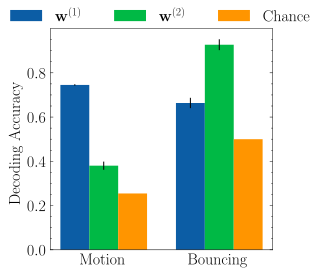

In [15]:
group_names = ["Motion", "Bouncing"]
latex_str = [r'$\mathbf{w}^{(1)}$', r'$\mathbf{w}^{(2)}$', 'Chance']


x = np.arange(len(group_names))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(4, 4))

for attribute, measurement in performance_mean.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=latex_str[multiplier], yerr=performance_std[attribute])
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Decoding Accuracy")
ax.set_xticks(x + width, group_names)
ax.xaxis.set_ticks_position('none')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

In [24]:
fig.savefig("figures/weight_decoding.pdf", bbox_inches='tight', pad_inches=0)

### PCA viz

In [26]:
import pandas as pd

In [27]:
R2 = R2.reshape(-1, R2.shape[2])
R3 = R3.reshape(-1, R3.shape[2])

In [28]:
R2_demean = R2 - np.mean(R2, axis=0)
R3_demean = R3 - np.mean(R3, axis=0)

In [29]:
r2_pca = PCA(n_components=2)
r3_pca = PCA(n_components=2)

In [30]:
r2_two_dim = r2_pca.fit_transform(R2_demean)
r3_two_dim = r3_pca.fit_transform(R3_demean)

In [31]:
motion_map = {0.:"Up", 1.:"Left", 2.:"Down", 3.:"Right"}
bouncing_map = {0: "Straight", 1: "Clockwise"}
df = pd.DataFrame({
    "PC1": r3_two_dim[:, 0],
    "PC2": r3_two_dim[:, 1],
    "Motion": [motion_map[i] for i in motion_cat],
    "Bouncing": [bouncing_map[i] for i in bouncing_cat]
})

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4], sharey=True, sharex=True)

sns.scatterplot(x='PC1', y='PC2', hue="Motion", ax=axes[1], data=df, s=35, hue_order=["Up", "Left", "Down", "Right"])
axes[1].set_ylabel("PC2", labelpad=-13.5)
axes[1].legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4, columnspacing=0.75)

sns.scatterplot(x='PC1', y='PC2', hue="Bouncing", ax=axes[0], data=df, s=35, hue_order=["Straight", "Clockwise"])
axes[0].legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, columnspacing=0.75)

fig.subplots_adjust(wspace=0.1)



In [43]:
fig.savefig("figures/clustering.pdf", bbox_inches='tight')